<a href="https://colab.research.google.com/github/hyunjune123/RL-for-Price-Trend-Recognition/blob/main/qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Libraries

In [ ]:
# This will create google drive directory as working directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Libraries used
import random
from datetime import datetime
import time
import pickle
import os
import pdb

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_uniform, Constant
from keras.regularizers import l2
import keras.backend as K

import numpy as np
import pandas as pd
import math


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from IPython.display import Image

# Introduction

In this experiment, we successfully trained a Q-value iteration based reinfocement learning model that learns increaing and decreasing trends. For convenience, we call the values generated in this research as stock prices. However, note that the model is not limited to price movements, but can be applied to various fields of studies including demography, physics, epidemiology, and so on.

The goal of the model is to decide how the price movement trend is today and decide which action among buy, hold, and sell would be optimal.

We first define the Q-learning model and try training the model on simple harmonic motion. Then we will train the model on noise and dampning added motion data set.

# Reinforcement Learning on simple harmonic motion

We aim to train the model on a simple harmonic motion of price values. This is done to ensure that the model converges on simple data and to confirm that the model learns its decision boundaries either to sell, hold, or buy at a given time step.
 

## Data generation

Data will be generated based on simple harmonic motion based on Hooke's law. Below is the generated data table of stock prices. 

In [18]:
# Code copied from https://alphaarchitect.com/2020/02/26/reinforcement-learning-for-trading/#note-54032-4
# Author : Druce Vertes

def shm_gen(dt=0.001,
            coef=100,     # coef = k/m
            amplitude=2, 
            start_trend=100, 
            trend_per_tick=0.0, 
            noise=0.0, 
            damping=0.0, 
            verbose=False):
    """Generate simple harmonic motion around trend, with noise and damping"""
    
    period = 2 * np.pi * np.sqrt(1/coef)

    if verbose:
        print("%s Amplitude: %.3f" % (time.strftime("%H:%M:%S"), amplitude))
        print("%s Period: %.3f" % (time.strftime("%H:%M:%S"), period))

    # initial stock price
    stock_price = start_trend + amplitude
    stock_velocity = 0.0
    
    trend_index = start_trend
    t = 0.0

    while True:
        # acceleration based on distance from trend
        acc = - coef * (stock_price - trend_index) 
        stock_velocity += acc * dt
        # add noise to velocity
        stock_velocity += np.random.normal(loc=0, scale=noise)
        # damp velocity by a % (could also make this a constant)
        stock_velocity *= (1-damping)
        # increment stock price
        stock_price += stock_velocity * tick_length
        # add noise; doesn't impact velocity which makes velocity a partly hidden state variable
        stock_price += np.random.normal(loc=0, scale=noise/2)
        
        yield(t, stock_price, trend_index)
        t += dt
# simulate market data
total_time=1
ticks = 1000
tick_length = total_time/ticks

# coef = k/m
coef=100
amplitude=2 
start_trend=100 
trend_per_tick=0.0 
noise=0.0 
damping=0.0 

period = 2 * np.pi * np.sqrt(1/coef)
print(period)
# gen = shm_gen(dt=total_time/ticks,
#               coef=coef,
#               amplitude=amplitude, 
#               start_trend=start_trend, 
#               trend_per_tick=trend_per_tick, 
#               noise=noise, 
#               damping=damping, 
#               verbose=1)

gen = shm_gen()

trend_series = []
stock_series = []
time_series = []

for i in range(ticks):
    t, stock_price, trend_index = next(gen)
    stock_series.append(stock_price)
    trend_series.append(trend_index)
    time_series.append(t)
    

svm_df = pd.DataFrame({'dateindex': time_series, 'trend' : trend_series, 'stock': stock_series})
svm_df['ma'] = svm_df['stock'].rolling(int(0.5*period*ticks)).mean()
svm_df['dateindex'] *= 1000
svm_df

0.6283185307179586


,dateindex,trend,stock,ma
0,0.0,100,101.999800,NaN
1,1.0,100,101.999400,NaN
2,2.0,100,101.998800,NaN
3,3.0,100,101.998000,NaN
4,4.0,100,101.997001,NaN
...,...,...,...,...
995,995.0,100,98.284832,99.338440
996,996.0,100,98.295205,99.327586
997,997.0,100,98.305749,99.316800
998,998.0,100,98.316462,99.306083


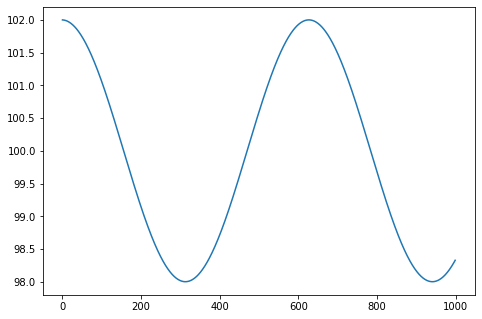

In [19]:
x = svm_df['dateindex']
y = svm_df['stock']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y)
ax.set_title = "Simple harmonic motion stock price"
ax.set_xlabel = "Timestep"
ax.set_ylabel = 'Price'

## Define Q-Learning agent 

We define the Q-learning agent here with the following setting.

* actions : Buy / Hold / Sell
* Discount rate (gamma) : 0.95
* Learning rate : 0.001
* Epsilon decay rate = 0.995

In [110]:
class Agent:
    
    def __init__(self,window,batchLen):

        # input parameter
        self.state_size = window
        self.batchLen = batchLen
        self.prev = None

        # hyper parameter
        self.g = 0.95 # discount rate
        self.epsilon = 1 # greedy-epsilon
        self.min_epsilon = 0.01
        self.decay = 0.995 #0.995 # epsilon will decay overtime
        self.model =  self.make_model(30,16,16,3,0.01, 0.001, 0.0675) # Qvalue NN approximator
        self.memory = pd.DataFrame(columns = ["state", "action", "next_state","reward","done"])
        self.memory_size = 100000
        self.total_reward = 0
        self.history = pd.DataFrame(columns = ["date", "price", "action", "reward","total_reward"])
        self.sample_size = 256
        self.reward_mult = 100
        self.total_reward_hist = []
        
        # constant parameter
        self.actionSpace = 3 # {sit = 0, buy = 1, sell = 2} for now...

    def make_model(self,in_dim, l1_num, l2_num, act_size, learn, reg, dropout):
        inputs = Input(shape=(in_dim,), name="Input")

        layer_1 = Dense(units=l1_num, 
                        activation="relu",
                        kernel_initializer = glorot_uniform(),
                        kernel_regularizer = l2(reg))(inputs)

        last = layer_1

        outputs = Dense(act_size, activation = 'linear',
                        name = 'Output')(last)

        model = Model(inputs = inputs, outputs = outputs)
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = learn))

        return model


    # Makes decision based on NN if epsilon value is low enough
    # otherwise random decision
    def act(self,state):
        # exploration
        if random.random() <= self.epsilon:
            act = random.randrange(self.actionSpace)
            
        # exploitation
        else:
            state = state.reshape(1,-1)
            qvals = self.model.predict(state)[0]
            act = np.argmax(qvals)

        assert act == 0 or act == 1 or act == 2
        
        return act
    
    # update agent's trade history memory
    # memory is used for training in an episode
    def update_memory(self,new_mem):
        if self.memory.shape[0] > self.memory_size:
            self.memory = self.memory[-self.memory_size:]
        self.memory = pd.concat([self.memory, new_mem], ignore_index=True)
    

    # Experience replay based update in Q-value NN approximator
    def update_agent_nn(self):
        memoryLen = len(self.memory)
        batch_len = self.batchLen
        samp_size = self.sample_size
        
        # Not enough memory
        if self.memory.shape[0] < samp_size:
            return
        
        minibatch = self.memory.sample(n=samp_size) 
        
        X_fit = np.concatenate(minibatch['state'].values)
        X_fit = X_fit.reshape((samp_size, self.state_size))
        Y_pred = self.model.predict(X_fit)

        minibatch['q'] = minibatch['reward']
        # if not done, add discount_rate  * Q-value for next state
        not_done = minibatch.loc[minibatch['done'] == False]
        X_observed = np.concatenate(not_done['next_state'].values)
        X_observed = X_observed.reshape((not_done.shape[0], self.state_size))
        next_q = np.amax(self.model.predict(X_observed), axis=1) 
       
      
        # update Q value for actions model took
        minibatch.loc[minibatch['done'] == False, 'q'] += self.g * next_q
        np.put_along_axis(Y_pred,
                          minibatch['action'].astype(int).values.reshape(samp_size, 1),
                          minibatch['q'].values.reshape(samp_size, 1),
                          axis=1)

        self.model.fit(X_fit, Y_pred,
                       epochs=1,
                       batch_size=batch_len,
                       verbose = 0)
        
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.decay
    

    # Supplementary functions below ...
            
    def reset(self):
        self.total_reward = 0
        self.history = self.history[0:0]
    
    def plot(self, episode_i, dir_name):
        current_directory = os.getcwd() + '/' + dir_name +'/'
        final_directory = os.path.join(current_directory, r'plot_%d' %episode_i)
        if not os.path.exists(final_directory):
           os.makedirs(final_directory)
        
        # Divide the graph into portions
        self.history['action'] = self.history['action'].map({0: 'sell', 1:'hold',2: 'buy'})
        portion = 1
        colors = {'sell' : 'red', 'hold' : 'black', 'buy' : 'blue'}
        legends = ['red', 'black', 'blue']
        for df in np.array_split(self.history, 5):
            '''
            groups = df.groupby("action")
            for name, group in groups:
                plt.plot(group["date"], group["price"], marker=".", linestyle="", label=name)
            plt.legend()
            '''
            if len(self.history) < 250:
                df = self.history
            fig, ax = plt.subplots()
            ax.scatter(df['date'], df['price'], 
                       c=df['action'].apply(lambda x: colors[x]),
                       s=3)
            ax.legend()
            my_file = "episode_"+str(episode_i)+"_part_"+str(portion)+".png"
            lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
            labels = ['sell', 'hold', 'buy']
            plt.legend(lines, labels)
            plt.savefig(os.path.join(final_directory, my_file))
            plt.close()
            portion += 1
            if len(self.history) < 250:
                break
        
    def save_history_csv(self, i, name):
        self.history.to_csv(name+'/episode_%d_history.csv' %i, index=False)
    # vectorized version of trade function for speed

    def trade(self, df):
        df_len = len(df)
        states = df['state']
        next_states = df['next_state']
        price_diff = df['price_diff']
        random_act_index = random.sample(range(0,df_len), 
                                        math.floor(self.epsilon*df_len-1))
        X_observed = np.concatenate(states)
        X_observed = X_observed.reshape((len(states), self.state_size))
        action_vec = np.argmax(self.model.predict(X_observed), axis = 1)
        for i in random_act_index:
            action_vec[i] = random.randrange(self.actionSpace)
        # actions are subtracted by 1 to make sell = -1, hold = 0, buy = 1
        # example. if price went up next day so that price difference is +10,
        #          then reward for buying is 1 * 10, while reward for selling is
        #          -1 * 10. 
        reward_vec = price_diff * (action_vec-1) * self.reward_mult
        done_vec = np.repeat(False, df_len)
        done_vec[df_len-1] = True
        self.total_reward = sum(reward_vec)
        # Record trade history for plot
        new_mem = {'date' : df['dates'],
                'price' : df['price'], 
                'action' : action_vec,
                'reward' : reward_vec, 
                'total_reward' : np.cumsum(reward_vec)}
        self.history = pd.DataFrame(new_mem)
    
        # Update memory
        new_mem = {'state' : states,
                    'action' : action_vec, 
                    'next_state' : next_states,
                    'reward' : reward_vec, 
                    'done' : done_vec}

        self.update_memory(pd.DataFrame(new_mem))

    def validate(self, i, dir_name, df):
        final_directory = os.getcwd() + '/' + dir_name

        df_len = len(df)
        states = df['state'].reset_index(drop=True)
        price_diff = df['price_diff'].reset_index(drop=True)
        X_observed = np.concatenate(states)
        X_observed = X_observed.reshape((len(states), self.state_size))
        action_vec = np.argmax(self.model.predict(X_observed), axis = 1)
        reward_vec = price_diff * (action_vec-1) * self.reward_mult

        print("Validation ended with reward : %d" %np.sum(reward_vec))
        df['action'] = action_vec
        fig, ax = plt.subplots()

        # plot validation
        df['action'] = df['action'].map({0: 'sell', 1:'hold',2: 'buy'})
        colors = {'sell' : 'red', 'hold' : 'black', 'buy' : 'blue'}
        legends = ['red', 'black', 'blue']
        ax.scatter(df['dates'], df['price'], 
                    c=df['action'].apply(lambda x: colors[x]),
                    s=3)
        ax.legend()
        my_file = name + "_"+"validation_"+str(i)+".png"
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
        labels = ['sell', 'hold', 'buy']
        plt.legend(lines, labels)
        plt.savefig(os.path.join(final_directory, my_file))
        plt.close()




        
            

## State Representation

We need to define the structure of our state space. There could be many possible state representations, from a very simple recent 30 days relative price vector to complex financial technical indicators. Below are some functions to build these states from stock price data.

In [21]:
# Simple recent 30 days price
# Input : stock price data frame
# Output : same data frame with 'state' and 'next_state' columns added.
#          state representation is [p1, p2, p3 .... p29, p30]
#          p = price - 100
def state_rp(agent, df):
    states = []
    next_states = []
    price_diffs = []
    dates = []
    prices = []
    for i in range(agent.state_size, len(df)-1):
        state = np.array((df['stock'])[i-agent.state_size:i])
        #states += [state]
        states += [(state - np.mean(state))/np.std(state)]
        next_state = np.array((df['stock'])[i-agent.state_size+1:i+1])
        #next_states += [next_state]
        next_states += [(next_state - np.mean(next_state))/np.std(next_state)]
        price_diffs += [(df['stock'][i]-df['stock'][i-1])]
        prices += [df['stock'][i-1]]
        dates += [df['dateindex'][i-1]]
    new_df = pd.DataFrame({'state':states, 'next_state':next_states,'price':prices,'dates':dates, 'price_diff':price_diffs})
    return new_df

## Training the agent

We train the agent for multiple episodes of trade simulations. For each episode, the agent (1) trades for one episode, (2) the trade history and performace is recorded, and (3) agent updates its neural network based on it's trade performance. We wish to see that as episode number increases, trade performance increases as well. The performance can be assessed by the variable total_reward.

In [88]:
# Let the agent trade for an entire episode and record it's decisions and performance.
        
def episodes_run(df, val_df, agent, episode_num, name):
    if not os.path.exists(name):
        os.makedirs(name)

    for i in range(0, episode_num):
        print("episode %d" %i)
        # Agent trades
        agent.trade(df)
    
        # QNN is updated
        agent.update_agent_nn()
    
        # Plot and save agent history of trade for each xth episode
        x = 200
        if (i+1) % x == 0:
            print("plotting...")
            agent.plot(i, name)
            agent.save_history_csv(i, name)
            agent.validate(i, name, val_df)

        # record total reward for this episode
        agent.total_reward_hist += [agent.total_reward]

        # Reset agent for next episode
        agent.reset()

def plot_total_reward(hist, name):
    x = range(0, len(hist))
    hist = [hist[i]/100 for i in range(0, len(hist))]
    plt.scatter(x, hist)
    plt.xlabel = "Episodes"
    plt.ylabel = "Total Reward"
    plt.savefig(name + "/total_reward.png")
    plt.close()
        

    

## Evaluation

A single episode of training won't be enough for the model to learn. Below, we will run 1000 episodes and record the model performace. For every 200th episode the performance plot will be saved in directory. A plot of total reward for each episode will be saved at the end.



In [ ]:
name = "simple_harmonic_motion"
agent = Agent(30, 1)
rl_df = state_rp(agent, svm_df)
train_df, val_df= np.split(rl_df, [int(.8 *len(rl_df))])
episodes_run(train_df, val_df, agent, 1000, name)
plot_total_reward(agent.total_reward_hist, name)




Total reward plot below shows that the model has converged after around 700 episodes. Also check out the individual plots in the current directory. We can see that there is clear decision boundaries depending on the price movement.

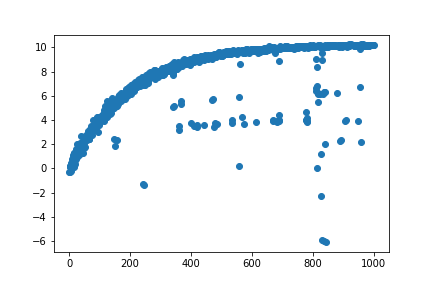

In [114]:
Image('simple_harmonic_motion/total_reward.png')

The epsode plots below shows that the model completely learned to maximize reward for the simple harmonic motion data set. When the price increases, the model decides to buy and when the price falls, the model decides to sell.

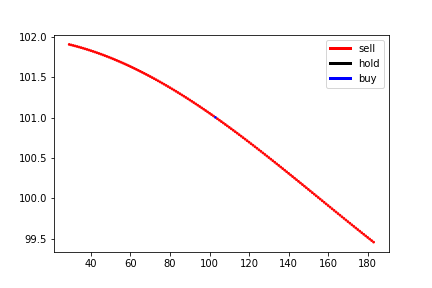

In [116]:
Image('simple_harmonic_motion/plot_799/episode_799_part_1.png')

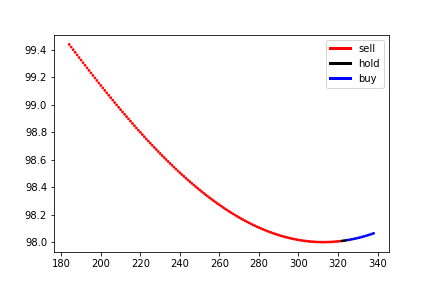

In [117]:
Image('simple_harmonic_motion/plot_799/episode_799_part_2.png')

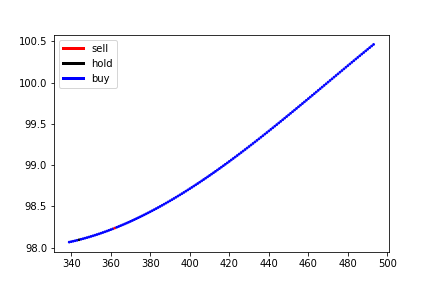

In [118]:
Image('simple_harmonic_motion/plot_799/episode_799_part_3.png')

# Reinforcement Learning on noise added simple harmonic motion

We add noise and dampning to the simple harmonic motion. This retains the stock price trend while adding randomness to the change of price. We want to see how the model would deal with random price changes. 

##Data Generation

In [96]:
total_time=1
ticks = 1000
tick_length = total_time/ticks

# coef = k/m
coef=100     
amplitude=1
start_trend=100 
trend_per_tick=0.0 
noise=0.2
damping=0.002

period = 2 * np.pi * np.sqrt(1/coef)

gen = shm_gen(dt=total_time/ticks,
              coef=coef,     # coef = k/m
              amplitude=amplitude, 
              start_trend=start_trend, 
              trend_per_tick=trend_per_tick, 
              noise=noise, 
              damping=damping, 
              verbose=1)

trend_series = []
stock_series = []
time_series = []

for i in range(ticks):
    t, stock_price, trend_index = next(gen)
    
    stock_series.append(stock_price)
    trend_series.append(trend_index)
    time_series.append(t)

noise_shm_df = pd.DataFrame({'dateindex': time_series, 'trend' : trend_series, 'stock': stock_series})
noise_shm_df['ma'] = noise_shm_df['stock'].rolling(int(0.5*period*ticks)).mean()
noise_shm_df

22:10:41 Amplitude: 1.000
22:10:41 Period: 0.628


,dateindex,trend,stock,ma
0,0.000,100,100.884835,NaN
1,0.001,100,101.022569,NaN
2,0.002,100,101.035576,NaN
3,0.003,100,101.057841,NaN
4,0.004,100,101.063636,NaN
...,...,...,...,...
995,0.995,100,97.224865,99.898279
996,0.996,100,97.395644,99.884368
997,0.997,100,97.392644,99.870419
998,0.998,100,97.514636,99.856444


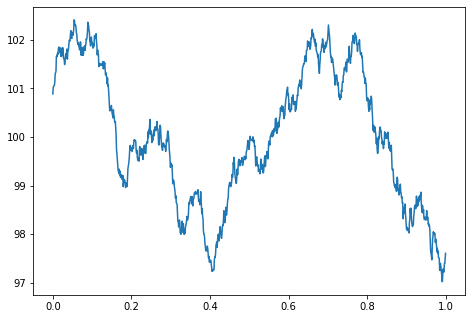

In [97]:
x = noise_shm_df['dateindex']
y = noise_shm_df['stock']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y)
ax.set_title = "Simple harmonic motion stock price"
ax.set_xlabel = "Timestep"
ax.set_ylabel = 'Price'

## Training on noise added simple harmonic motion

We train the same model on noise added data set. This time we train for 1,500 episodes up to time index 800. We use the remaining 200 time index data set as validation set.

In [ ]:
name = "shm_noise"
agent = Agent(30, 1)
rl_df = state_rp(agent, noise_shm_df)
train_df, val_df= np.split(rl_df, [int(.8 *len(rl_df))])
episodes_run(train_df, val_df, agent, 1200, name)
plot_total_reward(agent.total_reward_hist, name)

Total reward plot below shows that the model converges around 600th episode, with total reward ranging from 10 ~ 25.



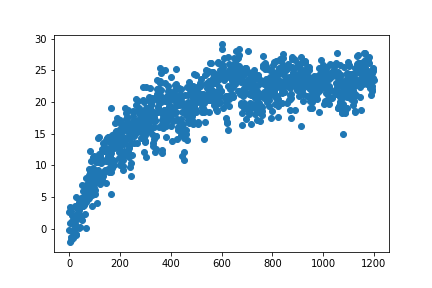

In [101]:
Image('shm_noise/total_reward.png')

Looking at the 800th episode plots, we see that the model tends to sell when there is a clear downward movement, and buy when there is upward movement. 

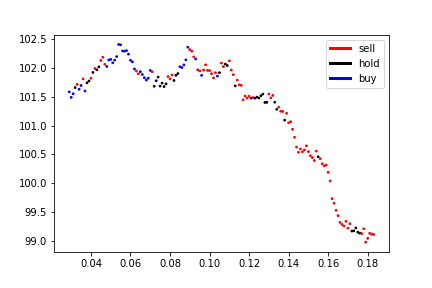

In [108]:
Image('shm_noise/plot_799/episode_799_part_1.png')

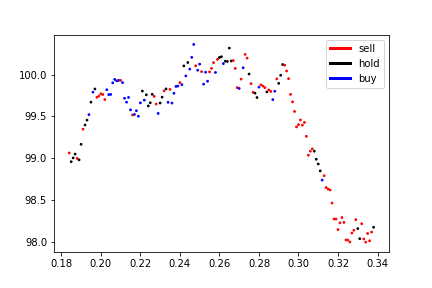

In [107]:
Image('shm_noise/plot_799/episode_799_part_2.png')

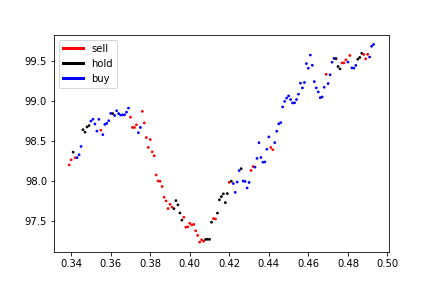

In [106]:
Image('shm_noise/plot_799/episode_799_part_3.png')

## Evaluation on validation data set

We use the validation data set to see how the model peroforms on unseen data set. The plot below is the model's trade history on the validation set after it's 800th train episode.

We see that the model tend to sell for the entire 200 days, as price fall in general. It also picks up the intervals when price seems to bounce up again. Total reward of the model trading for these 200 days ended up as -0.62, which is very decent. This means that although price fell from around 100.5 to 97, the model actively trading for 200 days only led to loss of -0.62.  

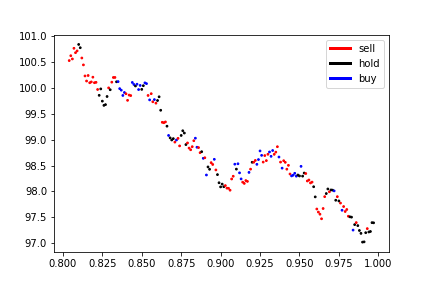

In [109]:
Image('shm_noise/shm_noise_validation_799.png')

# Conclusion

Reinforcement learning, specifically Q value iteration, seems to grasp the general trend of price movements. The model's decision based on the expected Q values computed by it's deep neural network can signal when the trend is shifting, and tell us the current optimal action to take. 

This Q-learning model is not limited to stock prices. We have arbitrary decided to call the generated values as stock prices, so these data points can represent other numbers like population, temperature, etc. 
